# 뉴스기사 분류모델

## 1. 형태소 분석엔진 설치 (Colab)

In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 19.73 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 39.8 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-09-19 00:54:27--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuse

## 2. 패키지 참조

### 1) helper 참조

In [2]:
import sys
#sys.path.append('../../')
import helper

### 2) 다른 패키지들 참조

In [3]:
import os
import numpy as np
import seaborn as sb
import requests

from pandas import DataFrame, read_excel
from konlpy.tag import Mecab
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 3. 데이터셋 준비하기
### 1) 뉴스기사 데이터셋
- 앞서 뉴스 모은 데이터 - 지금은 지워서 조회 불가능

In [4]:
origin = read_excel("./news.xlsx")
origin.head()

,category,content
0,"IT,과학","“갤럭시S9 20만 원대, 아이폰6S 0원!” 모비톡, 가정의 달 이벤트 '갤럭시노..."
1,"IT,과학",'모비톡' 단독으로 진행되는 5월 가정의 달 이벤트에 이용자들의 폭발적인 반응이 나...
2,"IT,과학","이 밖에도 '모비톡'은 '갤럭시노트8', 'V30' 구매 시 '닌텐도 스위치'를 증..."
3,"IT,과학","LG 그램’, 100만대 판매기념 한정판 나왔다 LG전자가 ‘그램’ 노트북 누적판매..."
4,"IT,과학",LG전자는 베스트샵 등 주요 매장에서 23일부터 그램 한정판 500대를 판매한다고 ...


### 2) 불어용 데이터셋

In [5]:
r = requests.get('https://data.hossam/kr/korean_stopwords.txt')
r.encoding='utf-8'
stopwords = r.text.split('\n')
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓', '!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '...', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '|', '~', '·', '—', '——', '‘', '’', '“', '”', '…', '、', '。', '〈', '〉', '《', '》', '가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공

## 4. 데이터 전처리
### 1) 뉴스기사에서 영어, 특수문자를 제거하고 한글만 남기기

In [6]:
df = origin.copy()

# 한글을 제외한 나머지 글자들을 빈 문자열로 대체
df['content'] = df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

# document 컬럼의 데이터들 중에서 빈 문자열만 존재하는 항목은 결측치로 대체
df['content'].replace('', np.nan, inplace=True)

# 전체 데이터 셋 크기 확인
print('데이터 크기: ', df['content'].shape)

# 결측치 확인
print('결측치 크기: ', df['content'].isna().sum())

데이터 크기:  (76275,)
결측치 크기:  456


### 2) 결측치 제거

In [7]:
df.dropna(inplace=True)
df.isna().sum()

category    0
content     0
dtype: int64

### 3) 종속 변수 라벨링
#### 종속변수 값 확인 및 종류를 딕셔너리로 변환

In [8]:
# 종속 변수 값의 종류
category = list(df['category].unique())
category

# 종속 변수 값의 종류를 딕셔너리로 변환
cat_dict = {}
for i, v in enumerate(category):
    cat_dict[v] = i
cat_dict

['IT,과학', '경제', '사회', '생활,문화', '세계', '정치']

#### 종속 변수 라벨링

In [10]:
df['category'] = df['category'].map(cate_dict)
df['category'].value_counts()

5    17446
1    14723
4    13668
2    12500
0    10721
3     6761
Name: category, dtype: int64

### 4) 뉴스 기사 형태소 분석

In [11]:
if sys.platform == 'win32':
    mecab = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")
else:
    mecab = Mecab()

# 문장내 형태소들을 저장할 리스트
word_set = []

# 덧글 내용에 대해 반복 처리
for i, v in enumerate(df['content']):
    # 덧글 하나에 대한 형태소 분석
    morphs = mecab.morphs(v)
    # print(morphs)
    # if i > 5:
    #     break

    # 형태소 분석 결과에서 불용어를 제외한 단어만 별도의 리스트로 생성
    confirm_words = []
    for j in morphs:
        if j not in stopwords:
            confirm_words.append(j)

    # 불용어를 제외한 형태소 리스트를 통째로 word_set에 저장함
    # -> word_set은 2차원 리스트가 된다. 1차원이 덧글 단위임
    word_set.append(confirm_words)

# 상위 3건만 출력해서 확인
word_set[:3]

[['갤럭시',
  '만',
  '원대',
  '아이폰',
  '모비',
  '톡',
  '가정',
  '달',
  '벤트',
  '갤럭시',
  '노트',
  '갤럭시',
  '갤럭시',
  '갤럭시',
  '갤럭시',
  '엣지',
  '아이폰',
  '아이폰',
  '아이폰',
  '다양',
  '휴대폰',
  '정보',
  '가득',
  '스마트폰',
  '공동',
  '구매',
  '거래',
  '플',
  '모비',
  '톡',
  '가정',
  '달',
  '벤트',
  '화제',
  '다'],
 ['모비',
  '톡',
  '단독',
  '진행',
  '는',
  '가정',
  '달',
  '벤트',
  '이용자',
  '폭발',
  '인',
  '반응',
  '나타나',
  '고',
  '다',
  '고가',
  '인기',
  '스마트폰',
  '파격',
  '판매',
  '한다는',
  '커뮤니티',
  '카페',
  '중심',
  '화제',
  '모으',
  '고',
  '는',
  '특히',
  '갤럭시',
  '만',
  '대',
  '아이폰',
  '는',
  '할',
  '부',
  '원금',
  '앞세워',
  '안드로이드',
  '인기',
  '기종',
  '중심',
  '큰',
  '폭',
  '할인',
  '펼치',
  '는',
  '게',
  '주된',
  '요인',
  '꼽힌다',
  '모비',
  '톡',
  '관계자',
  '면',
  '고마운',
  '감사',
  '마음',
  '담',
  '선물',
  '할',
  '기회',
  '은',
  '가정',
  '달',
  '맞',
  '공격',
  '인',
  '마케팅',
  '진행',
  '고',
  '다며',
  '독보',
  '인',
  '통신비',
  '절약',
  '플',
  '로서',
  '도',
  '최선',
  '다',
  '겠',
  '다고',
  '밝혔',
  '다'],
 ['밖',
  '도',
  '모비',
  '톡',
  '은',
  '갤럭시',
 

### 5) 형태소 토큰화
#### 전체 단어에 대한 토큰화

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)
print(f'전체 단어수: {len(tokenizer.word_index)}')

전체 단어수: 31264


#### 3회 이상 자주 등장하는 단어의 수 구하기

In [13]:
# 사용 빈도가 높다고 판단할 등장 회수
threshold = 3

# 전체 단어의 수
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트할 값
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s' % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 자주 등장하는 단어 집합의 크기 구하기 -> 이 값이 첫 번째 학습층의 input 수가 된다.
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합(vocabulary)의 크기 : 31264
등장 빈도가 3번 미만인 희귀 단어의 수: 12062
단어 집합에서 희귀 단어의 비율: 38.58111566018424
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7881098022552737
단어 집합의 크기 : 19204


#### 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 진행

In [14]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
print('토큰의 크기 :', len(token_set))

토큰의 크기 : 75819


In [15]:
token_set

[[1748,
  13,
  1991,
  258,
  14140,
  5536,
  2529,
  191,
  8281,
  1748,
  7797,
  1748,
  1748,
  1748,
  1748,
  13145,
  258,
  258,
  258,
  156,
  4224,
  224,
  2742,
  768,
  227,
  420,
  361,
  4999,
  14140,
  5536,
  2529,
  191,
  8281,
  2764,
  3],
 [14140,
  5536,
  1577,
  82,
  2,
  2529,
  191,
  8281,
  323,
  2463,
  9,
  1308,
  1749,
  6,
  3,
  5537,
  1036,
  768,
  4592,
  219,
  241,
  2054,
  1667,
  266,
  2764,
  4427,
  6,
  2,
  210,
  1748,
  13,
  17,
  258,
  2,
  11,
  154,
  6079,
  5838,
  4641,
  1036,
  3791,
  266,
  342,
  692,
  1401,
  2565,
  2,
  14,
  6612,
  1642,
  2989,
  14140,
  5536,
  165,
  18,
  1,
  274,
  1283,
  744,
  222,
  11,
  960,
  4,
  2529,
  191,
  448,
  1001,
  9,
  1594,
  82,
  6,
  38,
  5139,
  9,
  5839,
  7798,
  4999,
  904,
  7,
  1454,
  3,
  22,
  10,
  28,
  3],
 [887,
  7,
  14140,
  5536,
  4,
  1748,
  7797,
  420,
  40,
  1,
  15357,
  4923,
  27,
  768,
  122,
  7390,
  2,
  1,
  110,
  2667,
  58

#### 토큰화 결과의 길이가 0인 항목 찾기

In [16]:
# 토큰화 결과 길이가 0인 항목의 index 찾기
drop_target_index = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_target_index.append(i)

print("길이가 0인 항목의 수: ", len(drop_target_index))

print("길이가 0인 항목의 인덱스 모음: ", drop_target_index)

길이가 0인 항목의 수:  96
길이가 0인 항목의 인덱스 모음:  [1666, 14115, 14555, 14557, 14560, 14566, 15002, 17771, 17924, 17926, 17929, 17935, 19411, 21596, 21598, 21601, 21607, 23900, 23902, 23905, 23911, 24066, 31861, 31864, 31869, 31873, 31880, 31885, 31888, 31893, 31894, 31896, 31897, 31899, 31901, 31902, 31904, 31905, 31907, 31908, 31910, 31911, 31913, 31915, 31916, 31918, 31920, 31922, 31923, 31925, 31926, 31928, 31930, 31931, 31933, 31935, 31936, 31938, 31940, 31942, 31944, 31946, 31947, 31949, 31951, 31953, 31955, 31957, 31958, 31960, 31962, 31964, 31966, 31968, 31969, 31971, 31972, 31974, 31975, 31977, 31979, 31981, 31982, 31984, 31986, 38662, 63498, 63507, 65929, 65938, 68629, 68643, 69368, 69382, 70168, 70182]


#### 토큰화 결과의 길이가 0인 항목 삭제하기

In [17]:
token_set2 = np.asarray(token_set, dtype="object")

In [18]:
# 토큰 결과에서 해당 위치의 항목들을 삭제한다.
fill_token_set = np.delete(token_set2, drop_target_index, axis=0)

# 종속변수에서도 같은 위치의 항목들을 삭제해야 한다.
label_set = np.delete(df['category'].values, drop_target_index, axis=0)

print("독립변수(덧글) 데이터 수: ", len(fill_token_set))
print("종속변수(레이블) 데이터 수: ", len(label_set))

독립변수(덧글) 데이터 수:  75723
종속변수(레이블) 데이터 수:  75723


## 5. 탐색적 데이터 분석

### 1) 각 문장별로 몇 개의 단어를 포함하고 있는지 측정

In [19]:
word_counts = []

for s in fill_token_set:
    word_counts.append(len(s))

max_word_count = max(word_counts)
min_word_count = min(word_counts)

print('기사의 최대 단어수 :',max_word_count)
print('기사의 최소 단어수 :',min_word_count)

기사의 최대 단어수 : 252
기사의 최소 단어수 : 1


### 2) 히스토그램으로 단어 분포 수 확인

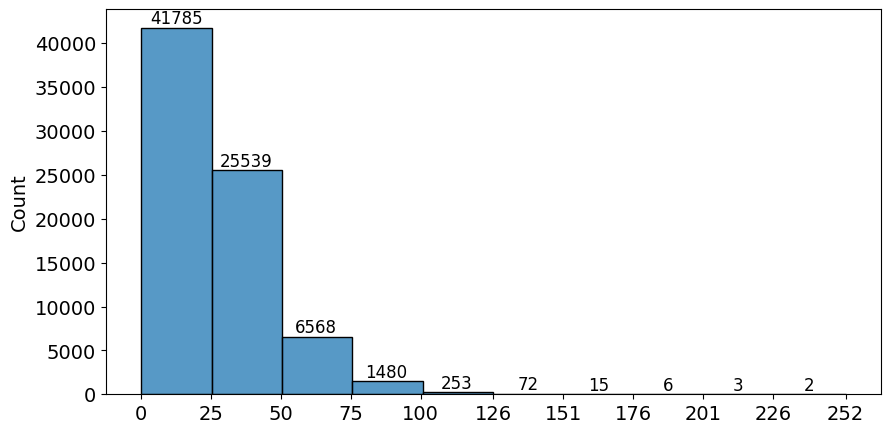

In [20]:
# 히스토그램의 범위 산정
hist_values, hist_bins = np.histogram(word_counts, range=(0, max_word_count), bins=10)
hist_bins = hist_bins.astype(np.int64)

plt.figure(figsize=(10, 5))
sb.histplot(word_counts, bins=10, binrange=(0, max_word_count))
plt.xticks(hist_bins, hist_bins)

for i, v in enumerate(hist_values):
    x = hist_bins[i] + ((hist_bins[i+1] - hist_bins[i]) / 2)
    plt.text(x=x, y=v, s=str(v), fontsize=12, verticalalignment='bottom', horizontalalignment='center')

plt.show()
plt.close()

## 6. 데이터 셋 분할하기

### 1) 랜덤시드 고정

In [21]:
np.random.seed(777)

### 2) 패딩처리

In [22]:
max_word_count = max(word_counts)
pad_token_set = pad_sequences(fill_token_set, maxlen=max_word_count)
pad_token_set

array([[   0,    0,    0, ..., 8281, 2764,    3],
       [   0,    0,    0, ...,   10,   28,    3],
       [   0,    0,    0, ..., 1975,    6,    3],
       ...,
       [   0,    0,    0, ...,    8,  490,  149],
       [   0,    0,    0, ...,    0,    0,  426],
       [   0,    0,    0, ...,    0,    0, 1622]], dtype=int32)

### 3) 훈련데이터와 검증데이터로 분할하기

In [23]:
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, label_set, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((53006, 252), (22717, 252), (53006,), (22717,))

### 4) 종속변수(Label)에 대한 one-hot-encoding

In [24]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## 7. 모델 개발

### 1) 모델 정의

In [25]:
#모델 개발
model = Sequential()

# input_dim의 크기는 토큰 생성시 지정한 최대 단어수(vocab_size)와 동일하게 설정
# output_dim의 크기는 input_dim보다 작은 값 중에서 설정
model.add(Embedding(input_dim = vocab_size, output_dim = 64))
model.add(GRU(256))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1229056   
                                                                 
 gru (GRU)                   (None, 256)               247296    
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 1477894 (5.64 MB)
Trainable params: 1477894 (5.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### 2) 학습하기

In [26]:
# 파일이 저장될 경로(폴더) 지정 (한글,공백이 포함되어 있을 경우 에러 발생함)
if sys.platform == 'win32':
    checkpoint_path = "D:\\tensorflow_checkpoint\\cp-{epoch:04d}-ckpt"
else:
    checkpoint_path = "./cp-{epoch:04d}-ckpt"

result = model.fit(x_train, y_train_one_hot, epochs=500, validation_data=(x_test, y_test_one_hot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
])

Epoch 1/500
1657/1657 [==============================] - ETA: 0s - loss: 0.6094 - acc: 0.7737
Epoch 1: val_loss improved from inf to 0.33294, saving model to ./model07-cp-0001-ckpt
1657/1657 [==============================] - 80s 44ms/step - loss: 0.6094 - acc: 0.7737 - val_loss: 0.3329 - val_acc: 0.8881 - lr: 0.0010
Epoch 2/500
1657/1657 [==============================] - ETA: 0s - loss: 0.2282 - acc: 0.9213
Epoch 2: val_loss improved from 0.33294 to 0.28418, saving model to ./model07-cp-0002-ckpt
1657/1657 [==============================] - 33s 20ms/step - loss: 0.2282 - acc: 0.9213 - val_loss: 0.2842 - val_acc: 0.9075 - lr: 0.0010
Epoch 3/500
1657/1657 [==============================] - ETA: 0s - loss: 0.1527 - acc: 0.9448
Epoch 3: val_loss did not improve from 0.28418
1657/1657 [==============================] - 26s 16ms/step - loss: 0.1527 - acc: 0.9448 - val_loss: 0.2875 - val_acc: 0.9061 - lr: 0.0010
Epoch 4/500
1657/1657 [==============================] - ETA: 0s - loss: 0.1213

## 8. 학습결과 평가

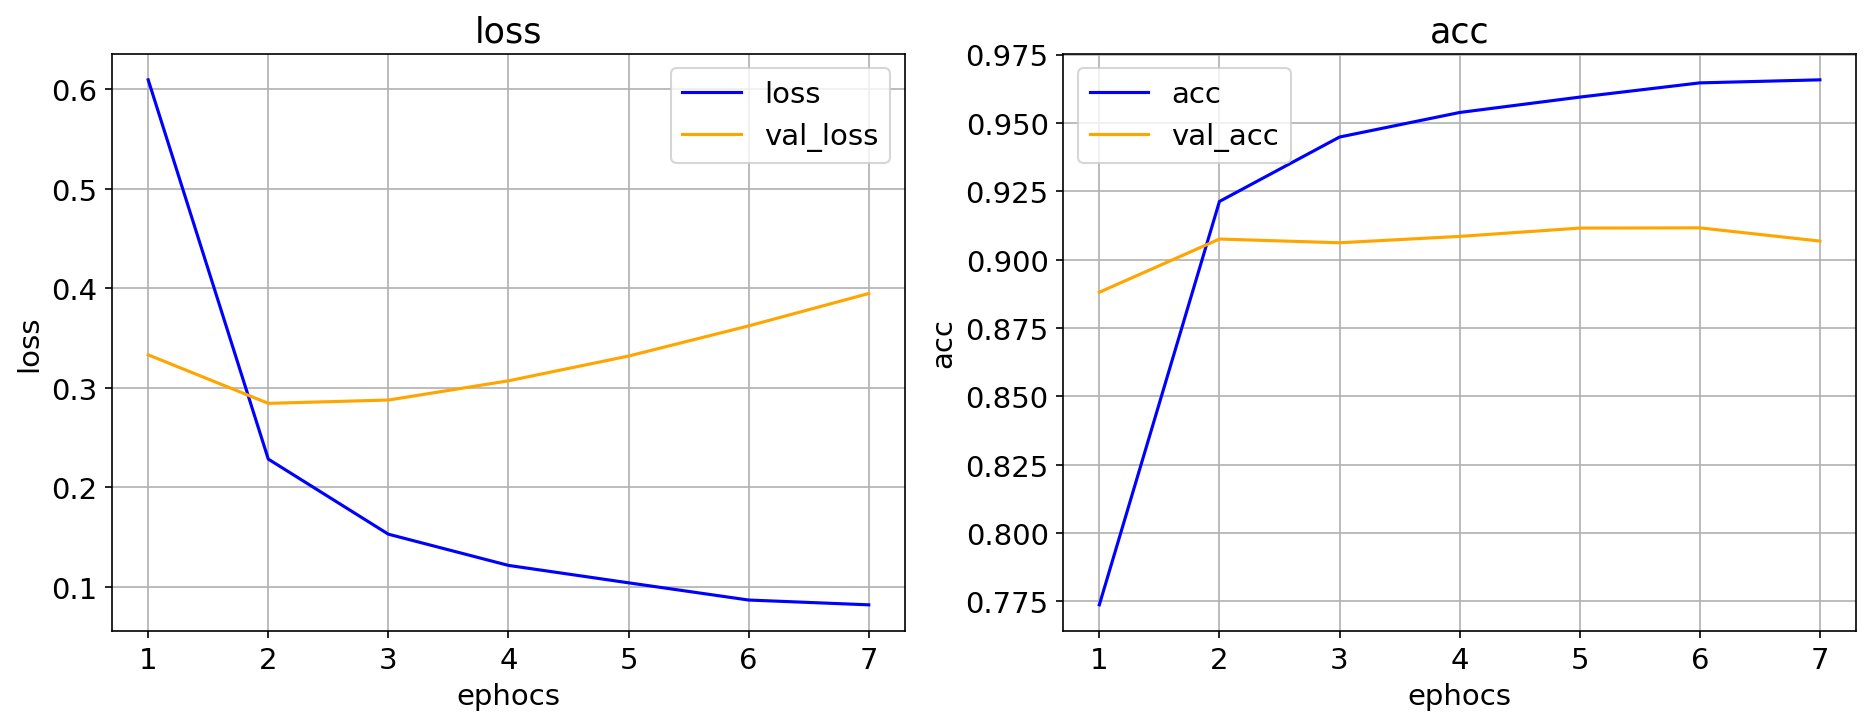

1657/1657 [==============================] - 10s 6ms/step - loss: 0.0806 - acc: 0.9661
최종 훈련 손실률: 0.080603, 최종 훈련 정확도: 0.966060
710/710 [==============================] - 4s 6ms/step - loss: 0.3946 - acc: 0.9068
최종 검증 손실률: 0.394594, 최종 검증 정확도: 0.906766


In [27]:
# helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train_one_hot)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test_one_hot)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

In [ ]:
# 학습 결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace = True)
result_df

In [ ]:
# Colab 그래프 한글글꼴 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm-/.cache/matplotlib -rf

from matplotlib import font_manager as fm
import matplotlib.pyplot as plt
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                  name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

In [ ]:
# 그래프 기본설정
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
sb.lineplot(x=result_df.index,
            y='loss',
            data=result_df,
            color='lightblue',
            label='훈련 손실률',
            ax=ax1)
sb.lineplot(x=result_df.index,
            y='val_loss',
            data=result_df,
            color='lightcoral',
            label='검증 손실률',
            ax = ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 정확도 그리기
sb.lineplot(x=result_df.index,
            y='acc',
            data=result_df,
            color='lightblue',
            label='훈련 정확도',
            ax=ax2)
sb.lineplot(x=result_df.index,
            y='val_acc',
            data=result_df,
            color='lightcoral',
            label='검증 정확도',
            ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [ ]:
evaluate1 = my_model.evaluate(pad_x_train, y_train)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))
evaluate2 = my_model.evaluate(pad_x_test, y_test)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

## 9. 학습 결과 적용

### 1) 훈련 데이터에 대한 예측 결과 산정

In [28]:
result = model.predict(x_train, batch_size=10)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

5301/5301 [==============================] - 20s 4ms/step
53006개의 검증 데이터가 6개의 경우의 수를 갖는다.


array([[5.09506535e-05, 9.99944806e-01, 1.95987195e-06, 7.96880215e-07,
        9.34880916e-07, 6.05109904e-07],
       [1.20451020e-07, 3.21981884e-06, 1.35438802e-06, 3.34382349e-07,
        9.99993682e-01, 1.33259050e-06],
       [1.08499955e-06, 1.04605682e-07, 9.99998689e-01, 3.90887323e-08,
        4.80682267e-08, 9.26700139e-08],
       ...,
       [1.21694915e-01, 1.39485359e-01, 2.33611882e-01, 8.13497677e-02,
        1.37898698e-01, 2.85959363e-01],
       [9.25657275e-07, 2.77600811e-05, 7.69017277e-07, 2.28560066e-06,
        9.99966025e-01, 2.29183001e-06],
       [1.81552224e-07, 8.48464552e-08, 1.90765306e-07, 5.13537266e-08,
        1.11312590e-06, 9.99998450e-01]], dtype=float32)

### 2) 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [29]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([1, 4, 2, ..., 5, 4, 5])

### 3) 학습 결과 확인

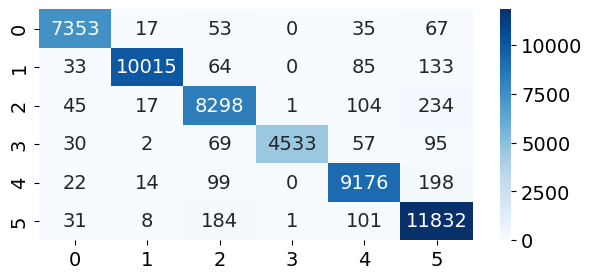

In [30]:
kdf = DataFrame({
    'train': y_train,
    'pred' : arg_result
})

kdf['pred'] = kdf['pred'].astype('int')

cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7, 3))
sb.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.show()
plt.close()

## 10. 임의의 문장에 대한 분류

In [31]:
# 임의의 문장
comment = [
        '민주당 총력 투쟁, 한덕수 해임건의안 제출…이재명, 단식 이어간다',
        '중저신용 대출’에 힘썼더니… 인터넷 뱅킹 대출 연체율 사상 최고',
        '영국 노동당 대표 “다음 총선 이기면 브렉시트 협정 개정”',
        '日 어패류 수입량 1년 새 24.8%↓…日 맥주는 323.7% 급증',
        '화웨이 열풍’ 中에서 아이폰15 예약판매 시작 동시 매진',
        '전국 곳곳에 소나기…예년 이맘때보다 더워'
]

# 형태소 분석 엔진
if sys.platform == 'win32':
    mecab = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")
else:
    mecab = Mecab()

# 불용어를 제거한 형태소들이 저장될 리스트
word_set = []

# 문장 수 만큼 반복
for c in comment:
    # 형태소 분석
    morphs = mecab.morphs(c)
    # 불용어 제거
    tmp_word = []
    for j in morphs:
        if j not in stopwords:
            tmp_word.append(j)

    word_set.append(tmp_word)

# 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 수행
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)

# 최대 길이에 맞춰서 패딩 처리
pad_token_set = pad_sequences(token_set, maxlen=max_word_count)

# 전처리가 완료된 말뭉치를 학습모델에 적용하여 예측하기
result = model.predict(pad_token_set)

# 결과 분석
arg_result = np.argmax(result, axis=-1)

for i, v in enumerate(arg_result):
    print("%d, %s >> %s" % (v, category[v], comment[i]))

1/1 [==============================] - 0s 93ms/step
5, 정치 >> 민주당 총력 투쟁, 한덕수 해임건의안 제출…이재명, 단식 이어간다
5, 정치 >> 중저신용 대출’에 힘썼더니… 인터넷 뱅킹 대출 연체율 사상 최고
5, 정치 >> 영국 노동당 대표 “다음 총선 이기면 브렉시트 협정 개정”
4, 세계 >> 日 어패류 수입량 1년 새 24.8%↓…日 맥주는 323.7% 급증
5, 정치 >> 화웨이 열풍’ 中에서 아이폰15 예약판매 시작 동시 매진
0, IT,과학 >> 전국 곳곳에 소나기…예년 이맘때보다 더워
